In [14]:
!pip install segmentation_models

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.2 MB/s eta 0:00:00


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 78.6 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile
import os

# Path where the contents will be extracted
extract_path = "/content/drive/MyDrive/WaterSegmentation"

print("Extraction completed at:", extract_path)
print("Contents:", os.listdir(extract_path))


Extraction completed at: /content/drive/MyDrive/WaterSegmentation
Contents: ['data']


In [4]:
#Load TIFF images
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from skimage.io import imsave

In [5]:
#Define dataset paths
DATASET_PATH = "/content/drive/MyDrive/WaterSegmentation"
TRAIN_PATH = f"{DATASET_PATH}/data/images"
LABEL_PATH = f"{DATASET_PATH}/data/labels"

In [6]:
# Example: load one image from the train folder
sample_image_path = os.path.join(TRAIN_PATH, os.listdir(TRAIN_PATH)[0])
sample_mask_path = os.path.join(LABEL_PATH, os.listdir(LABEL_PATH)[0])

with rasterio.open(sample_image_path) as src:
    img = src.read()  # (bands, height, width)
    profile = src.profile

with rasterio.open(sample_mask_path) as msk_src:
    mask = msk_src.read(1)  # mask is usually a single channel

print("Image shape:", img.shape)   # (bands, H, W)
print("Mask shape:", mask.shape)   # (H, W)

/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Image shape: (12, 128, 128)
Mask shape: (128, 128)


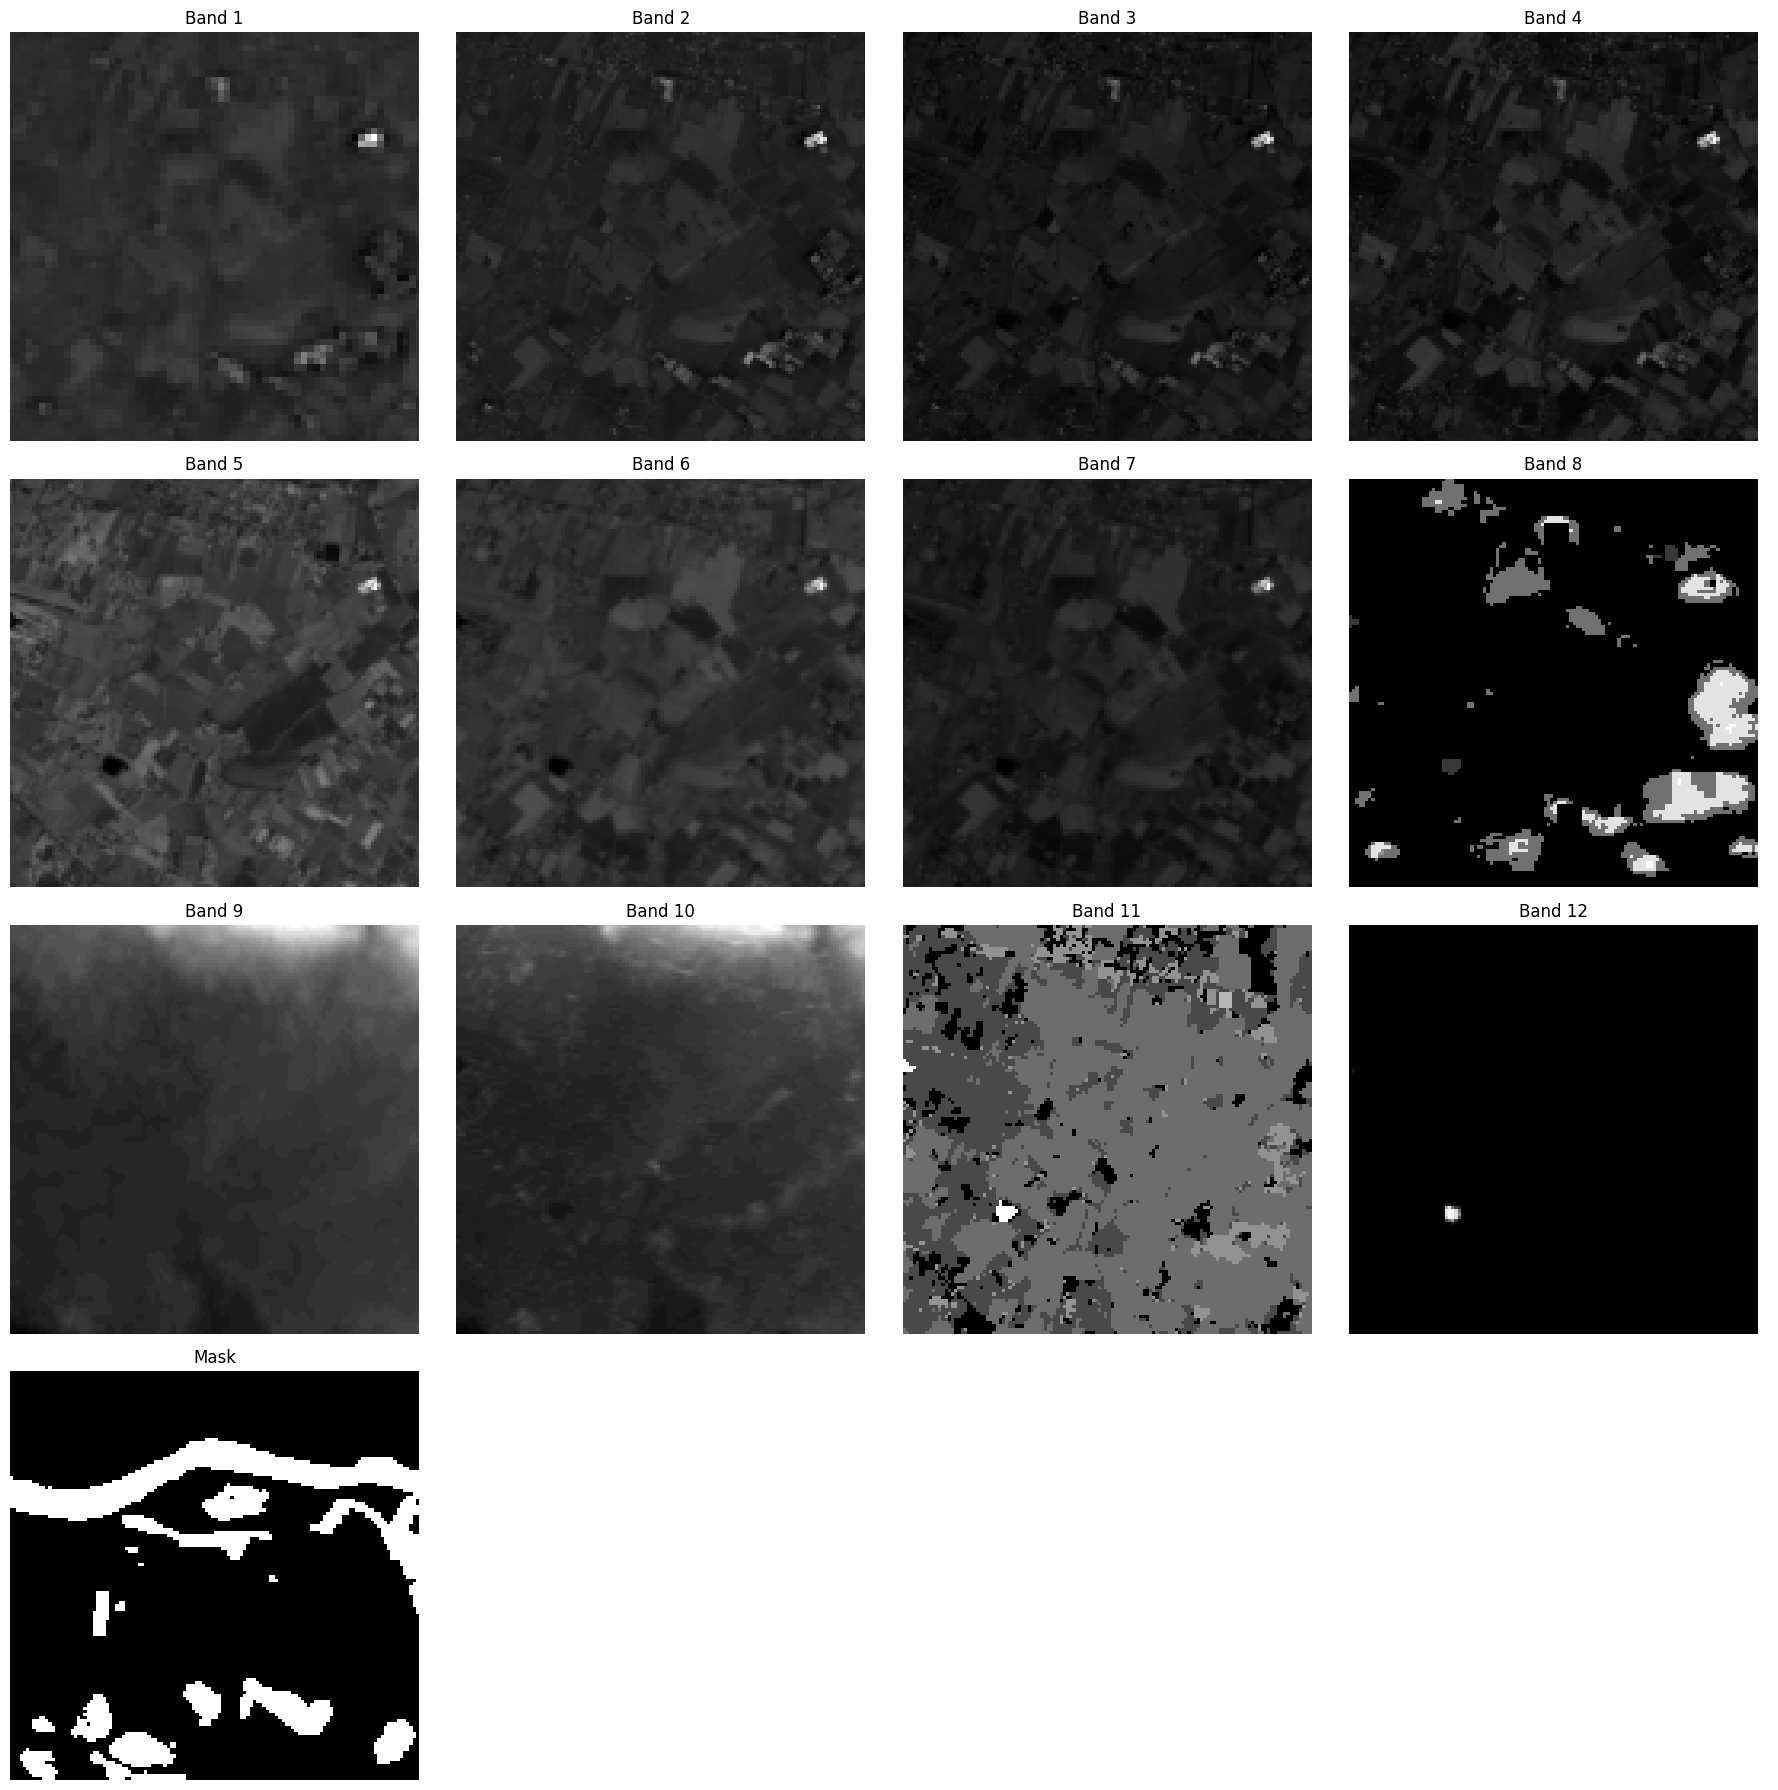

In [ ]:
import matplotlib.pyplot as plt

# total = 12 bands + 1 mask = 13
fig, axes = plt.subplots(4, 4, figsize=(18, 18))

# flatten axes for easy indexing
axes = axes.flatten()

# Plot 12 bands
for i in range(img.shape[0]):
    axes[i].imshow(img[i], cmap="gray")
    axes[i].set_title(f"Band {i+1}")
    axes[i].axis("off")

# Mask
axes[12].imshow(mask, cmap="gray")
axes[12].set_title("Mask")
axes[12].axis("off")

# Hide unused subplots (if any)
for j in range(13, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [8]:
import os

train_images = os.listdir(TRAIN_PATH)
train_masks = os.listdir(LABEL_PATH)

print("Number of images:", len(train_images))
print("Number of masks:", len(train_masks))


Number of images: 306
Number of masks: 456


In [ ]:
import os

image_files = sorted(os.listdir(TRAIN_PATH))  # ['0.tif', '1.tif', ...]
mask_files = sorted(os.listdir(LABEL_PATH))   # ['1.png', '2.png', ...]

# # Match mask names to image names (assuming masks correspond to images with +1 index)
matched_images = []
matched_masks = []

for img_file in image_files:
    img_idx = int(img_file.split(".")[0])  #Extract number from image filename
    mask_file = f"{img_idx}.png"  # Try to find the same number
    if mask_file in mask_files:
        matched_images.append(img_file)
        matched_masks.append(mask_file)

print("Matched samples:", len(matched_images), len(matched_masks))


Matched samples: 306 306


In [10]:
from sklearn.model_selection import train_test_split

train_imgs, val_imgs, train_masks, val_masks = train_test_split(
    matched_images, matched_masks, test_size=0.2, random_state=42
)

print("Train samples:", len(train_imgs))
print("Validation samples:", len(val_imgs))


Train samples: 244
Validation samples: 62


In [26]:
import albumentations as A

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_filenames, mask_filenames, image_dir, mask_dir, batch_size=8, shuffle=True, augment=False):
        self.image_filenames = list(image_filenames)
        self.mask_filenames = list(mask_filenames)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment

        # Define augmentation pipeline
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5)
        ])

        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        batch_images = self.image_filenames[index*self.batch_size:(index+1)*self.batch_size]
        batch_masks = self.mask_filenames[index*self.batch_size:(index+1)*self.batch_size]

        if len(batch_images) == 0:
            batch_images = [self.image_filenames[0]]
            batch_masks = [self.mask_filenames[0]]

        X = np.zeros((len(batch_images), 128, 128, 12), dtype=np.float32)
        y = np.zeros((len(batch_masks), 128, 128, 1), dtype=np.float32)

        for i, (img_file, mask_file) in enumerate(zip(batch_images, batch_masks)):
            # load image
            with rasterio.open(os.path.join(self.image_dir, img_file)) as src:
                img = src.read().astype(np.float32)  # (bands, H, W)
                # Normalize each band
                img_norm = np.zeros_like(img, dtype=np.float32)
                for b in range(img.shape[0]):
                    band = img[b]
                    img_norm[b] = (band - band.min()) / (band.max() - band.min() + 1e-8)
                img_norm = np.transpose(img_norm, (1,2,0))  # HWC

            # load mask
            with rasterio.open(os.path.join(self.mask_dir, mask_file)) as msk_src:
                mask = msk_src.read(1).astype(np.float32)

            # Apply augmentation if enabled
            if self.augment:
                augmented = self.aug(image=img_norm, mask=mask)
                img_norm = augmented['image']
                mask = augmented['mask']

            X[i] = img_norm
            y[i, ..., 0] = mask

        return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

    def on_epoch_end(self):
        if self.shuffle:
            temp = list(zip(self.image_filenames, self.mask_filenames))
            np.random.shuffle(temp)
            self.image_filenames, self.mask_filenames = zip(*temp)
            self.image_filenames = list(self.image_filenames)
            self.mask_filenames = list(self.mask_filenames)


In [27]:
train_gen = DataGenerator(train_imgs, train_masks, TRAIN_PATH, LABEL_PATH, batch_size=16, augment=True)
val_gen = DataGenerator(val_imgs, val_masks, TRAIN_PATH, LABEL_PATH, batch_size=16, augment=False)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
from segmentation_models import Unet

# Build U-Net with ResNet34 encoder
model = Unet(
    backbone_name='resnet34',
    input_shape=(128,128,12),
    encoder_weights=None,  # مفيش pretrained weights لأن عندك 12 band
    classes=1,
    activation='sigmoid'
)

# Ensure all layers are trainable
for layer in model.layers:
    layer.trainable = True

In [29]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

In [30]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + dice_loss(y_true, y_pred)


In [31]:
# -------- Build & Compile --------
model.compile(optimizer='adam',
              loss=bce_dice_loss,
              metrics=['accuracy', iou_metric])

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 128, 128,  │          0 │ -                 │
│                     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 128, 128,  │         36 │ data[0][0]        │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_68   │ (None, 134, 134,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 64, 64,    │     37,632 │ zero_padding2d_6… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 64, 64,    │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 64, 64,    │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_69   │ (None, 66, 66,    │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 32, 32,    │          0 │ zero_padding2d_6… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 32, 32,    │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 32, 32,    │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_70   │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 32, 32,    │     36,864 │ zero_padding2d_7… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 32, 32,    │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 32, 32,    │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_71   │ (None, 34, 34,    │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 32, 32,    │     36,864 │ zero_padding2d_7… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 32, 32,    │      4,096 │ stage1_unit1_rel

 Total params: 24,484,405 (93.40 MB)

 Trainable params: 24,467,037 (93.33 MB)

 Non-trainable params: 17,368 (67.84 KB)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5",
        save_best_only=True,
        monitor="val_loss"
    ),
    tf.keras.callbacks.EarlyStopping(
        patience=10,
        restore_best_weights=True,
        monitor="val_loss"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,         # Reduce learning rate by half
        patience=5,         # Wait for 5 epochs without improvement
        verbose=2,          # Print all changes
        min_lr=1e-7,        # Minimum learning rate
        min_delta=1e-5,     # Minimum change in val_loss to be considered significant
        mode='auto'         # Depends on the type of monitor (min or max)
    )
]

In [33]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.12/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7920 - iou_metric: 0.3732 - loss: 1.0418

16/16 ━━━━━━━━━━━━━━━━━━━━ 169s 7s/step - accuracy: 0.7946 - iou_metric: 0.3806 - loss: 1.0312 - val_accuracy: 0.7744 - val_iou_metric: 0.0025 - val_loss: 19946.1602 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8773 - iou_metric: 0.5880 - loss: 0.6638

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 533ms/step - accuracy: 0.8776 - iou_metric: 0.5883 - loss: 0.6633 - val_accuracy: 0.7711 - val_iou_metric: 0.0082 - val_loss: 2327.6382 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9022 - iou_metric: 0.6544 - loss: 0.5690

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 609ms/step - accuracy: 0.9019 - iou_metric: 0.6536 - loss: 0.5700 - val_accuracy: 0.7337 - val_iou_metric: 0.0577 - val_loss: 830.5204 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.8963 - iou_metric: 0.6293 - loss: 0.5666

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 594ms/step - accuracy: 0.8960 - iou_metric: 0.6283 - loss: 0.5681 - val_accuracy: 0.7758 - val_iou_metric: 0.0380 - val_loss: 30.8452 - learning_rate: 0.0010
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9006 - iou_metric: 0.6340 - loss: 0.5598

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 526ms/step - accuracy: 0.9004 - iou_metric: 0.6335 - loss: 0.5600 - val_accuracy: 0.8571 - val_iou_metric: 0.3718 - val_loss: 1.0867 - learning_rate: 0.0010
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 503ms/step - accuracy: 0.9039 - iou_metric: 0.6439 - loss: 0.5496 - val_accuracy: 0.8753 - val_iou_metric: 0.4773 - val_loss: 2.9271 - learning_rate: 0.0010
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 518ms/step - accuracy: 0.8980 - iou_metric: 0.6637 - loss: 0.5295 - val_accuracy: 0.8687 - val_iou_metric: 0.3942 - val_loss: 1.2893 - learning_rate: 0.0010
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.9163 - iou_metric: 0.6885 - loss: 0.4835

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 633ms/step - accuracy: 0.9155 - iou_metric: 0.6864 - loss: 0.4867 - val_accuracy: 0.8767 - val_iou_metric: 0.4756 - val_loss: 0.7329 - learning_rate: 0.0010
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 568ms/step - accuracy: 0.9127 - iou_metric: 0.6741 - loss: 0.4854 - val_accuracy: 0.8836 - val_iou_metric: 0.4912 - val_loss: 1.7360 - learning_rate: 0.0010
Epoch 10/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8982 - iou_metric: 0.6522 - loss: 0.5376

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 592ms/step - accuracy: 0.8984 - iou_metric: 0.6530 - loss: 0.5366 - val_accuracy: 0.9026 - val_iou_metric: 0.5906 - val_loss: 0.7030 - learning_rate: 0.0010
Epoch 11/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.9091 - iou_metric: 0.5938 - loss: 0.5646

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 534ms/step - accuracy: 0.9085 - iou_metric: 0.5959 - loss: 0.5631 - val_accuracy: 0.9032 - val_iou_metric: 0.5947 - val_loss: 0.5953 - learning_rate: 0.0010
Epoch 12/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 502ms/step - accuracy: 0.9027 - iou_metric: 0.6734 - loss: 0.5088 - val_accuracy: 0.9095 - val_iou_metric: 0.6128 - val_loss: 0.6234 - learning_rate: 0.0010
Epoch 13/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.9054 - iou_metric: 0.6513 - loss: 0.4928

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 590ms/step - accuracy: 0.9053 - iou_metric: 0.6513 - loss: 0.4929 - val_accuracy: 0.9180 - val_iou_metric: 0.6689 - val_loss: 0.5294 - learning_rate: 0.0010
Epoch 14/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 447ms/step - accuracy: 0.8872 - iou_metric: 0.6311 - loss: 0.5686 - val_accuracy: 0.8676 - val_iou_metric: 0.5337 - val_loss: 0.7353 - learning_rate: 0.0010
Epoch 15/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 501ms/step - accuracy: 0.9012 - iou_metric: 0.6341 - loss: 0.5078 - val_accuracy: 0.9113 - val_iou_metric: 0.6402 - val_loss: 0.7167 - learning_rate: 0.0010
Epoch 16/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9146 - iou_metric: 0.6786 - loss: 0.4569

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 535ms/step - accuracy: 0.9144 - iou_metric: 0.6793 - loss: 0.4573 - val_accuracy: 0.9128 - val_iou_metric: 0.6523 - val_loss: 0.5009 - learning_rate: 0.0010
Epoch 17/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 492ms/step - accuracy: 0.9135 - iou_metric: 0.6732 - loss: 0.4819 - val_accuracy: 0.9022 - val_iou_metric: 0.5971 - val_loss: 1.0729 - learning_rate: 0.0010
Epoch 18/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 501ms/step - accuracy: 0.9049 - iou_metric: 0.6643 - loss: 0.4867 - val_accuracy: 0.9111 - val_iou_metric: 0.6199 - val_loss: 0.5523 - learning_rate: 0.0010
Epoch 19/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 437ms/step - accuracy: 0.9177 - iou_metric: 0.6924 - loss: 0.4492 - val_accuracy: 0.9176 - val_iou_metric: 0.6520 - val_loss: 0.5206 - learning_rate: 0.0010
Epoch 20/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 503ms/step - accuracy: 0.9094 - iou_metric: 0.6944 - loss: 0.4599 - val_accuracy: 0.9164 - val_iou_metric: 0.6365 - val_loss: 0.5031 - learning_rate: 0.0010
Epoch 21/100


16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 499ms/step - accuracy: 0.9172 - iou_metric: 0.6991 - loss: 0.4464 - val_accuracy: 0.9181 - val_iou_metric: 0.6497 - val_loss: 0.4779 - learning_rate: 0.0010
Epoch 22/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.9091 - iou_metric: 0.6467 - loss: 0.5038

16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 578ms/step - accuracy: 0.9092 - iou_metric: 0.6481 - loss: 0.5025 - val_accuracy: 0.9200 - val_iou_metric: 0.6776 - val_loss: 0.4467 - learning_rate: 0.0010
Epoch 23/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.9090 - iou_metric: 0.7133 - loss: 0.4618

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 755ms/step - accuracy: 0.9094 - iou_metric: 0.7130 - loss: 0.4605 - val_accuracy: 0.9248 - val_iou_metric: 0.7007 - val_loss: 0.4076 - learning_rate: 0.0010
Epoch 24/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 468ms/step - accuracy: 0.9171 - iou_metric: 0.6847 - loss: 0.4433 - val_accuracy: 0.8074 - val_iou_metric: 0.4588 - val_loss: 0.9516 - learning_rate: 0.0010
Epoch 25/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 502ms/step - accuracy: 0.9112 - iou_metric: 0.6732 - loss: 0.4665 - val_accuracy: 0.9285 - val_iou_metric: 0.6997 - val_loss: 0.4126 - learning_rate: 0.0010
Epoch 26/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 512ms/step - accuracy: 0.9213 - iou_metric: 0.7059 - loss: 0.4255 - val_accuracy: 0.9098 - val_iou_metric: 0.6906 - val_loss: 0.4468 - learning_rate: 0.0010
Epoch 27/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9216 - iou_metric: 0.7294 - loss: 0.3870

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 515ms/step - accuracy: 0.9213 - iou_metric: 0.7281 - loss: 0.3892 - val_accuracy: 0.9253 - val_iou_metric: 0.6923 - val_loss: 0.4016 - learning_rate: 0.0010
Epoch 28/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 503ms/step - accuracy: 0.9231 - iou_metric: 0.7283 - loss: 0.4171 - val_accuracy: 0.9227 - val_iou_metric: 0.6948 - val_loss: 0.4197 - learning_rate: 0.0010
Epoch 29/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.9268 - iou_metric: 0.7146 - loss: 0.3937

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 525ms/step - accuracy: 0.9263 - iou_metric: 0.7144 - loss: 0.3952 - val_accuracy: 0.9278 - val_iou_metric: 0.7191 - val_loss: 0.3900 - learning_rate: 0.0010
Epoch 30/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9195 - iou_metric: 0.7151 - loss: 0.4379

16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 587ms/step - accuracy: 0.9193 - iou_metric: 0.7137 - loss: 0.4388 - val_accuracy: 0.9266 - val_iou_metric: 0.7188 - val_loss: 0.3809 - learning_rate: 0.0010
Epoch 31/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 496ms/step - accuracy: 0.9274 - iou_metric: 0.7150 - loss: 0.3960 - val_accuracy: 0.9260 - val_iou_metric: 0.6963 - val_loss: 0.3896 - learning_rate: 0.0010
Epoch 32/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 428ms/step - accuracy: 0.9143 - iou_metric: 0.6957 - loss: 0.4286 - val_accuracy: 0.9079 - val_iou_metric: 0.6373 - val_loss: 0.4829 - learning_rate: 0.0010
Epoch 33/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 514ms/step - accuracy: 0.9163 - iou_metric: 0.7025 - loss: 0.4360 - val_accuracy: 0.9245 - val_iou_metric: 0.6849 - val_loss: 0.3964 - learning_rate: 0.0010
Epoch 34/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 445ms/step - accuracy: 0.9191 - iou_metric: 0.7316 - loss: 0.4053 - val_accuracy: 0.9255 - val_iou_metric: 0.6750 - val_loss: 0.4104 - learning_rate: 0.0010
Epoch 35/100


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 558ms/step - accuracy: 0.9201 - iou_metric: 0.7244 - loss: 0.3997 - val_accuracy: 0.9358 - val_iou_metric: 0.7329 - val_loss: 0.3603 - learning_rate: 5.0000e-04
Epoch 37/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 440ms/step - accuracy: 0.9244 - iou_metric: 0.7228 - loss: 0.3973 - val_accuracy: 0.9330 - val_iou_metric: 0.7194 - val_loss: 0.3845 - learning_rate: 5.0000e-04
Epoch 38/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 535ms/step - accuracy: 0.9229 - iou_metric: 0.7586 - loss: 0.3708 - val_accuracy: 0.9337 - val_iou_metric: 0.7175 - val_loss: 0.3805 - learning_rate: 5.0000e-04
Epoch 39/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 423ms/step - accuracy: 0.9214 - iou_metric: 0.7206 - loss: 0.3944 - val_accuracy: 0.9323 - val_iou_metric: 0.7188 - val_loss: 0.3809 - learning_rate: 5.0000e-04
Epoch 40/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 492ms/step - accuracy: 0.9177 - iou_metric: 0.7326 - loss: 0.3976 - val_accuracy: 0.9312 - val_iou_metric: 0.6964 - val_loss: 0.4012 - learning_rate: 5.00

In [34]:
if os.path.exists("best_model.h5"):
    print("Loading best_model.h5 weights...")
    model.load_weights("best_model.h5")

Loading best_model.h5 weights...


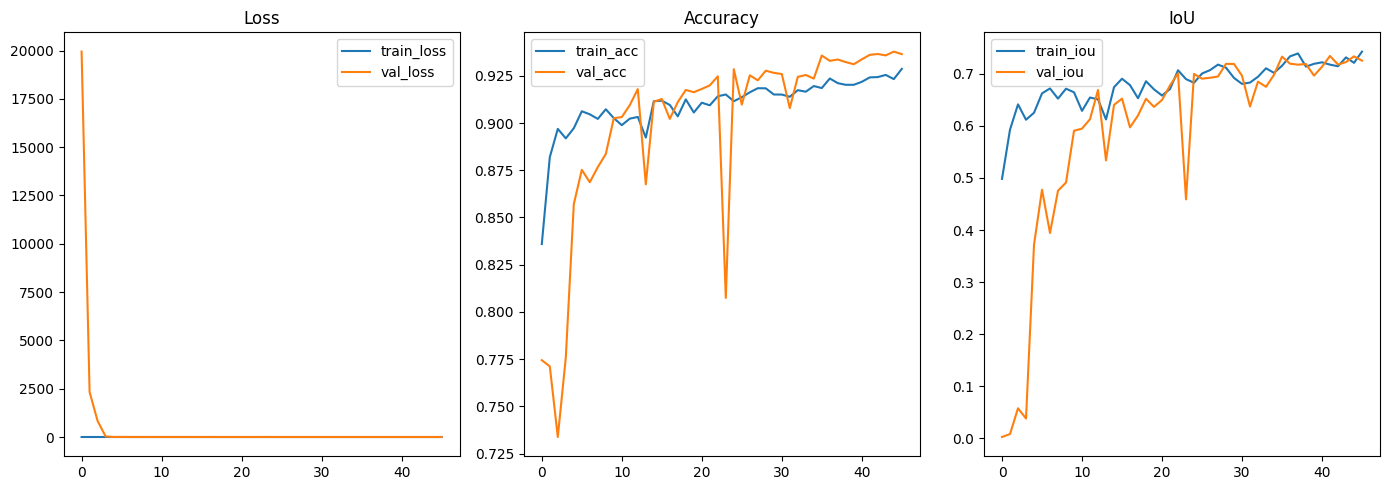

In [ ]:
if 'history' in globals() and hasattr(history, 'history'):
    h = history.history
    plt.figure(figsize=(14,5))
    # Loss
    plt.subplot(1,3,1)
    plt.plot(h.get('loss', []), label='train_loss')
    plt.plot(h.get('val_loss', []), label='val_loss')
    plt.title('Loss')
    plt.legend()
    # Accuracy
    plt.subplot(1,3,2)
    if 'accuracy' in h or 'acc' in h:
        acc_key = 'accuracy' if 'accuracy' in h else 'acc'
        plt.plot(h.get(acc_key, []), label='train_acc')
        plt.plot(h.get('val_'+acc_key, []), label='val_acc')
        plt.title('Accuracy')
        plt.legend()
    else:
        plt.title('Accuracy not found in history')
    # IoU
    plt.subplot(1,3,3)
    # Metric name might be 'iou_metric' or similar in history
    iou_keys = [k for k in h.keys() if 'iou' in k.lower()]
    if len(iou_keys) >= 1:
        key = iou_keys[0]
        val_key = 'val_' + key if 'val_' + key in h else None
        plt.plot(h.get(key, []), label='train_iou')
        if val_key:
            plt.plot(h.get(val_key, []), label='val_iou')
        plt.title('IoU')
        plt.legend()
    else:
        plt.title('IoU not found in history')
    plt.tight_layout()
    plt.show()
else:
    print("No history object found to plot training curves.")

In [36]:
test_gen = val_gen
results = model.evaluate(test_gen, verbose=1)
print("Evaluate results (loss, accuracy, iou):", results)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 312ms/step - accuracy: 0.9346 - iou_metric: 0.7304 - loss: 0.3697
Evaluate results (loss, accuracy, iou): [0.3820306658744812, 0.9358018636703491, 0.7131829261779785]


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


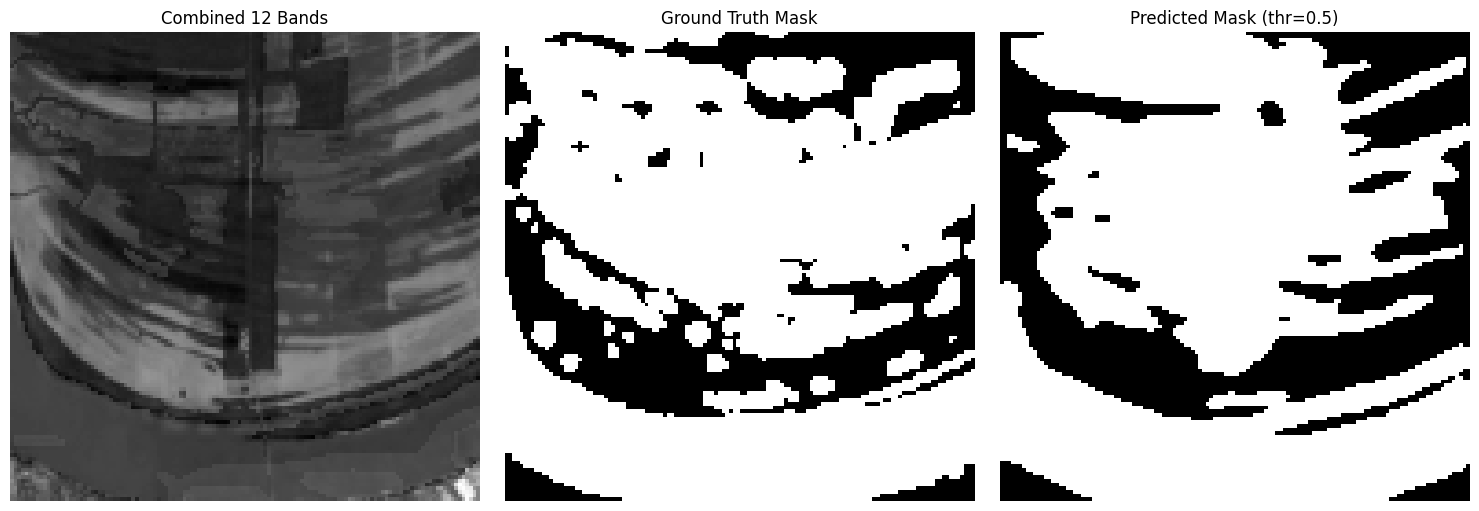

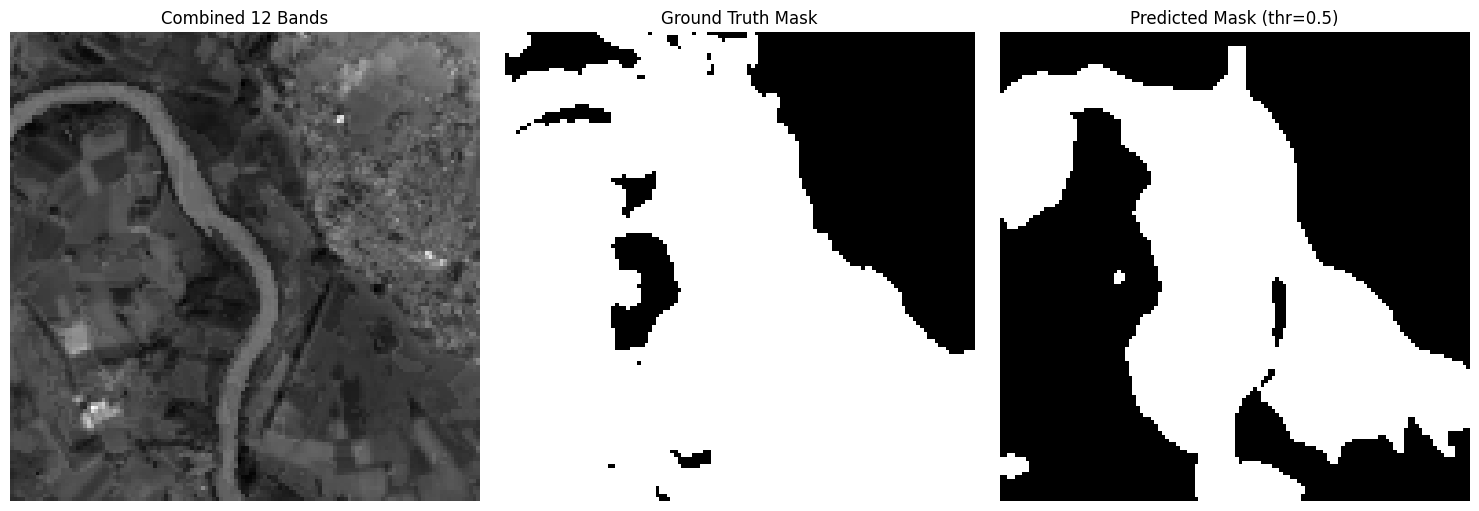

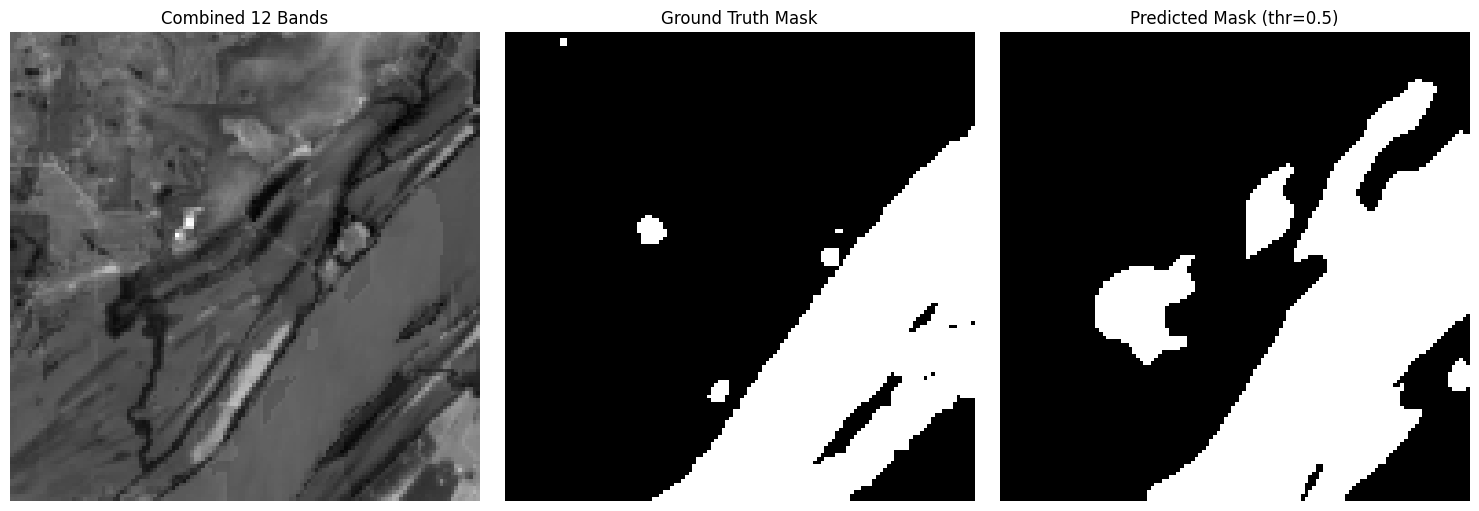

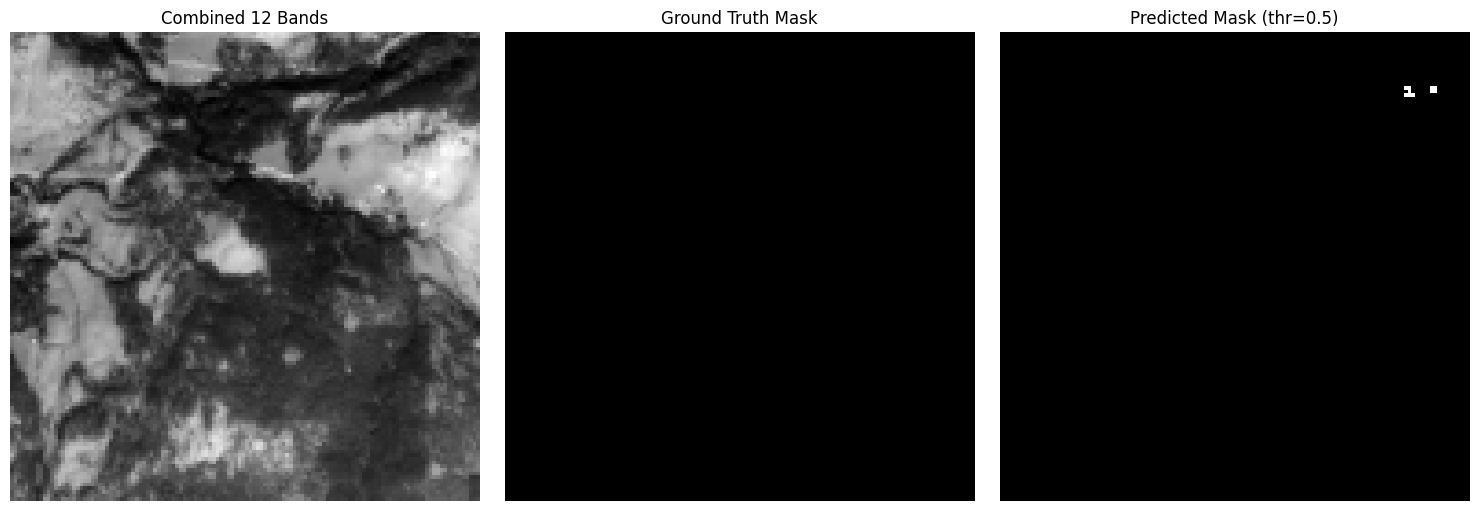

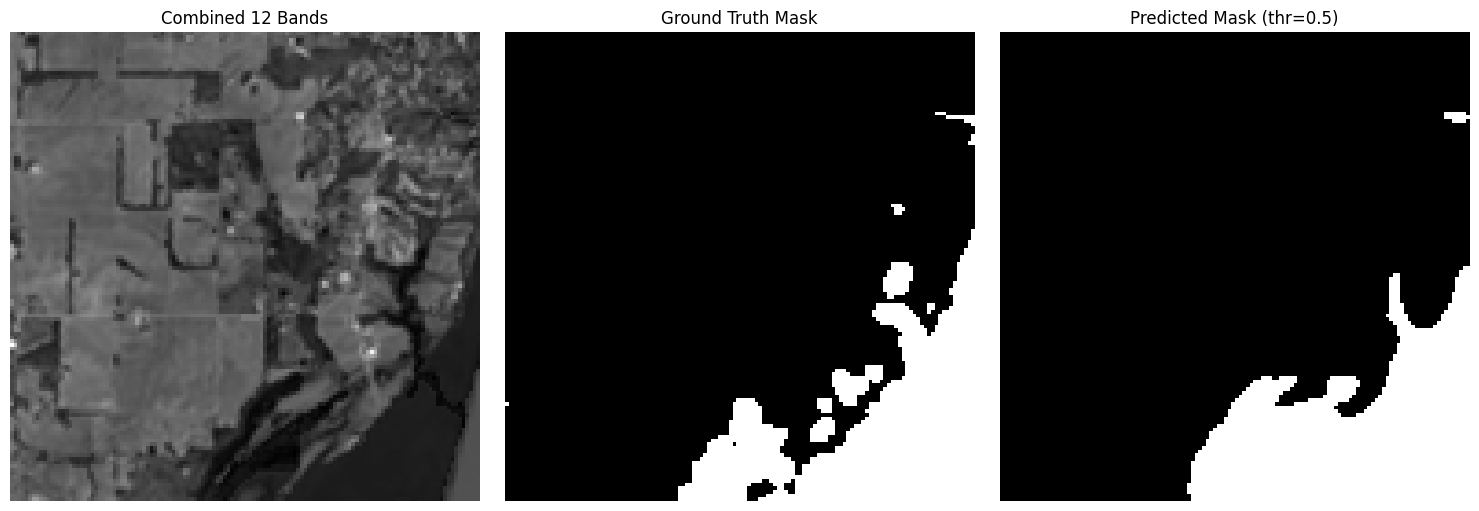

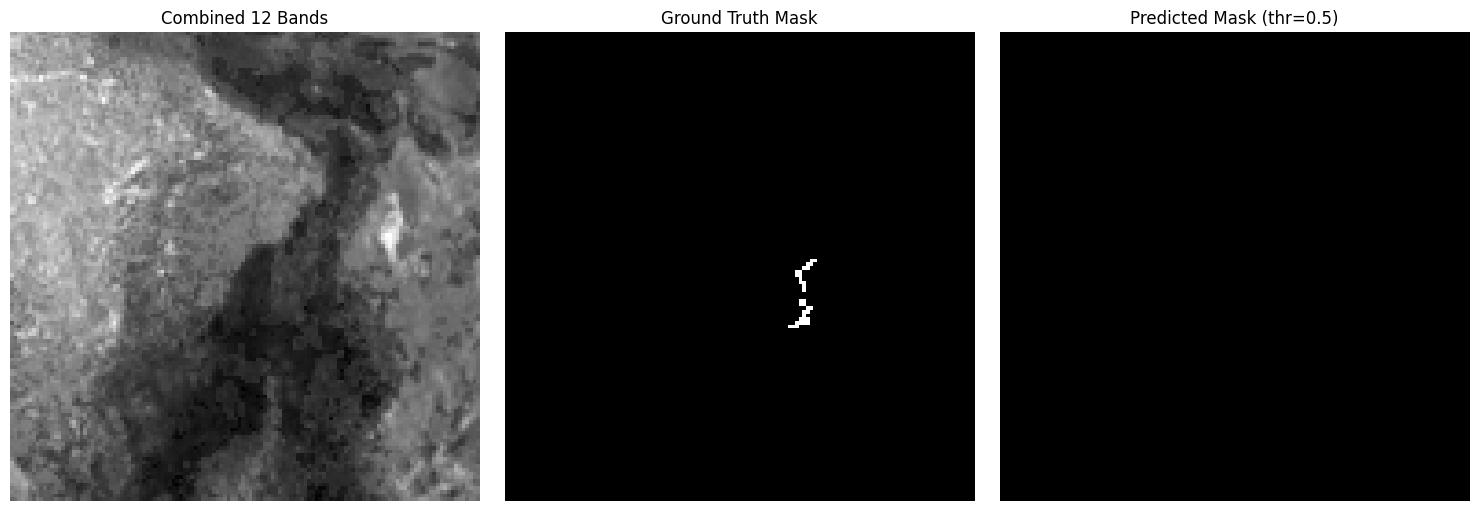

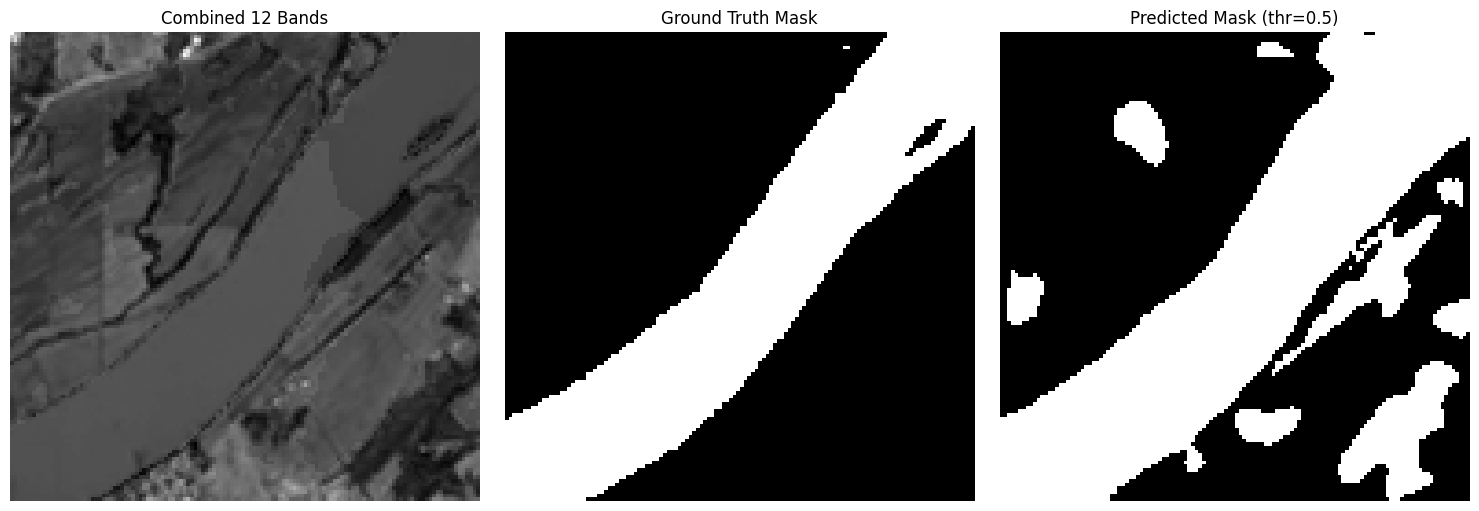

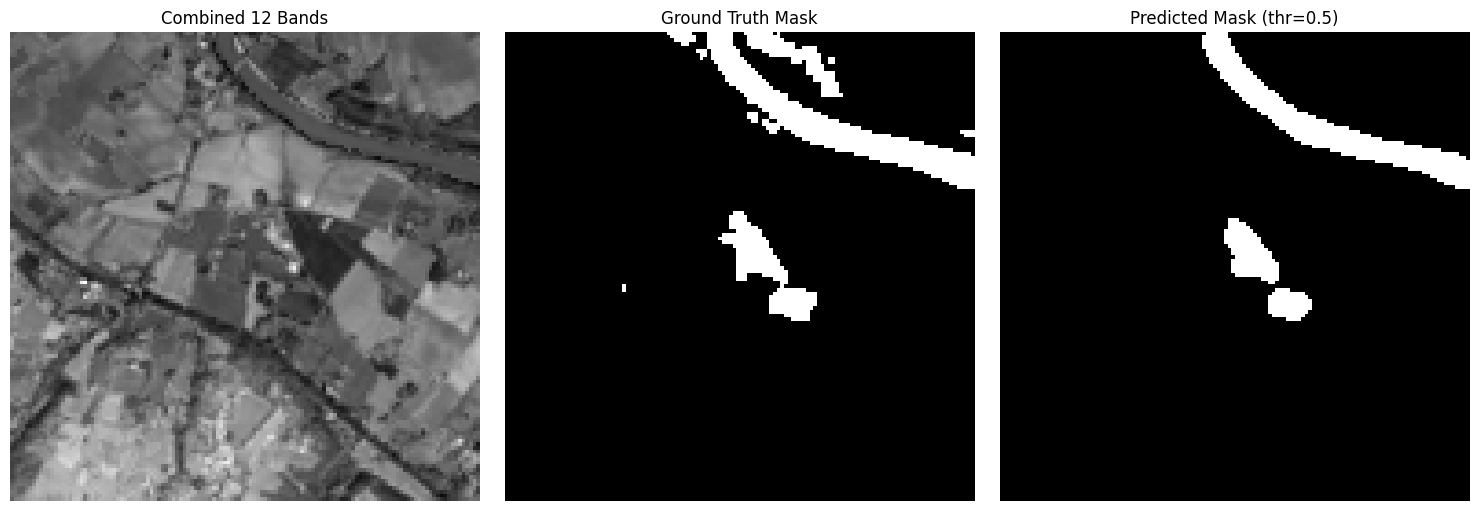

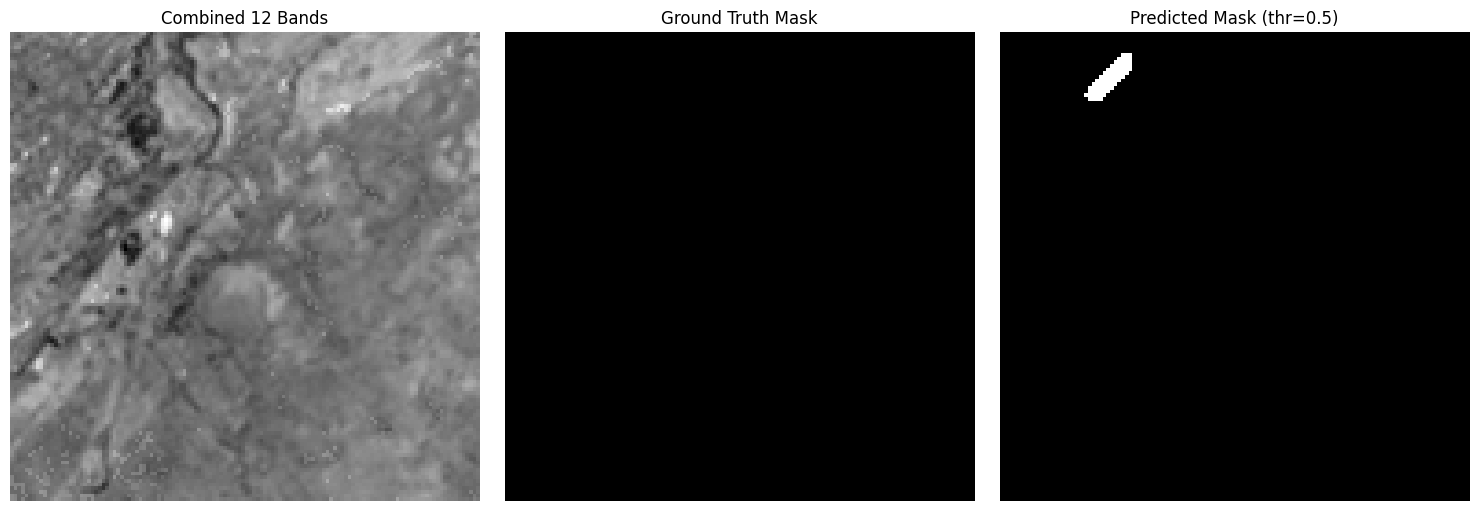

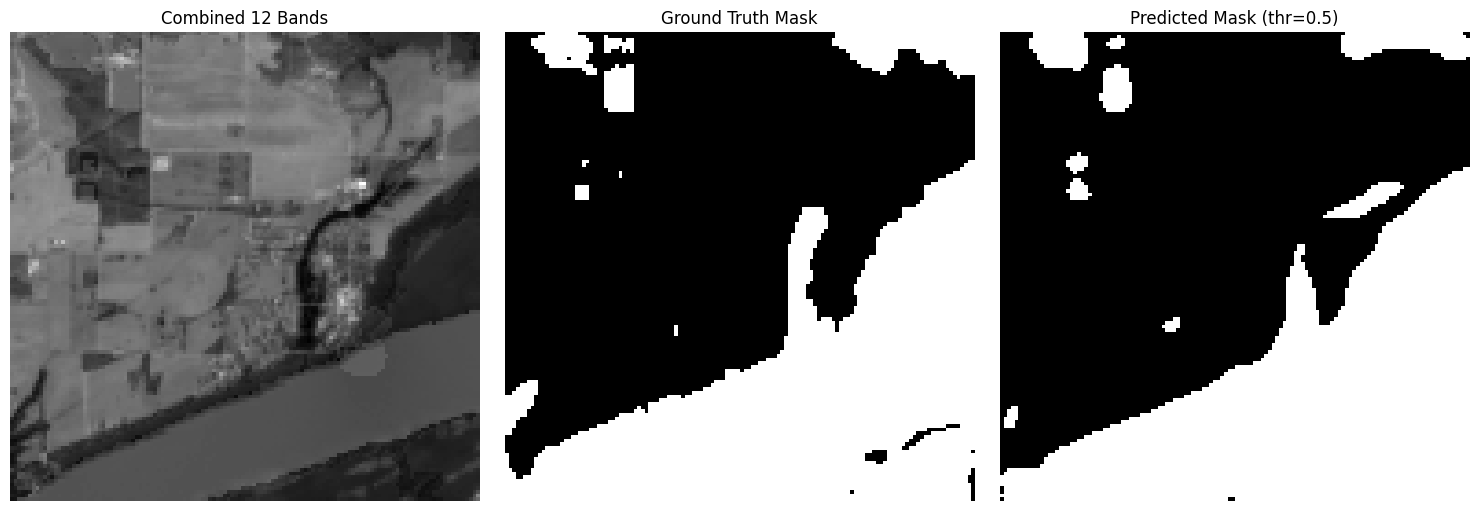

Saved predictions to: predictions


In [ ]:
from matplotlib.image import imsave

def visualize_prediction_combined(gen, model, n_samples=3, out_dir="predictions", threshold=0.5):
    os.makedirs(out_dir, exist_ok=True)
    samples_shown = 0

    for batch_idx in range(len(gen)):
        X_batch, y_batch = gen[batch_idx]
        preds = model.predict(X_batch)

        for i in range(X_batch.shape[0]):
            if samples_shown >= n_samples:
                break

            x = X_batch[i]        # (H, W, 12)
            y_true = y_batch[i, ..., 0]
            y_pred = preds[i, ..., 0]
            y_pred_bin = (y_pred >= threshold).astype(np.uint8)

            # Combine the 12 bands into a single image by averaging
            combined_img = np.mean(x, axis=-1)  # H x W, values 0-1
            combined_img = np.clip(combined_img, 0, 1)

            # Plot them side by side
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            axes[0].imshow(combined_img, cmap='gray')
            axes[0].set_title("Combined 12 Bands")
            axes[0].axis('off')

            axes[1].imshow(y_true, cmap='gray')
            axes[1].set_title("Ground Truth Mask")
            axes[1].axis('off')

            axes[2].imshow(y_pred_bin, cmap='gray')
            axes[2].set_title(f"Predicted Mask (thr={threshold})")
            axes[2].axis('off')

            plt.tight_layout()
            plt.show()

            # Save the prediction
            save_path = os.path.join(out_dir, f"pred_batch{batch_idx}_sample{i}.png")
            imsave(save_path, (y_pred_bin * 255).astype(np.uint8))

            samples_shown += 1

        if samples_shown >= n_samples:
            break

    print(f"Saved predictions to: {out_dir}")

# Use the function
# Update the function to display 10 images
visualize_prediction_combined(test_gen, model, n_samples=10, out_dir="predictions", threshold=0.5)



In [ ]:
from google.colab import files

files.download("best_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>